In [1]:
zip_path = "C:/Users/MUSAWENKOSI NYAWO/Downloads/chest_xray.zip"


In [2]:
import zipfile


zip_path = "C:/Users/MUSAWENKOSI NYAWO/Downloads/chest_xray.zip"
extract_path = "chest_xray"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)
    print("Dataset extracted to:", extract_path)


Dataset extracted to: chest_xray


In [3]:
import os

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Datasets
train_dataset = datasets.ImageFolder(root=os.path.join(extract_path, "train"), transform=transform)
val_dataset   = datasets.ImageFolder(root=os.path.join(extract_path, "val"), transform=transform)
test_dataset  = datasets.ImageFolder(root=os.path.join(extract_path, "test"), transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [6]:
import torch.optim as optim
import torch.nn as nn

# Example CNN model (replace with your actual model if needed)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate and move model to device
model = SimpleCNN(num_classes=len(train_dataset.classes)).to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


Epoch 1/5, Train Loss: 0.7299, Val Loss: 0.6892
Epoch 2/5, Train Loss: 0.6660, Val Loss: 0.6772
Epoch 3/5, Train Loss: 0.6458, Val Loss: 0.6662
Epoch 4/5, Train Loss: 0.6253, Val Loss: 0.6843
Epoch 5/5, Train Loss: 0.5821, Val Loss: 0.6856


In [7]:
# --- Export trained model to TorchScript format ---
import torch

model.eval()
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Match input shape
traced_model = torch.jit.trace(model, dummy_input)

# Save it
torch.jit.save(traced_model, "pneumonia_model_mobile.pt")
print("✅ Model saved as pneumonia_model_mobile.pt")


✅ Model saved as pneumonia_model_mobile.pt


In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))


[[268 262]
 [171 443]]
              precision    recall  f1-score   support

      cancer       0.61      0.51      0.55       530
   no cancer       0.63      0.72      0.67       614

    accuracy                           0.62      1144
   macro avg       0.62      0.61      0.61      1144
weighted avg       0.62      0.62      0.62      1144



In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize


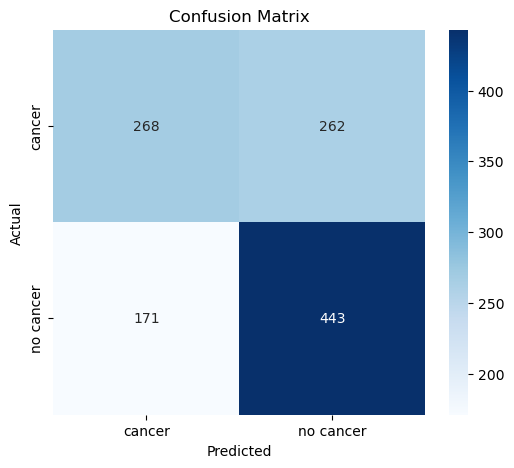

In [10]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


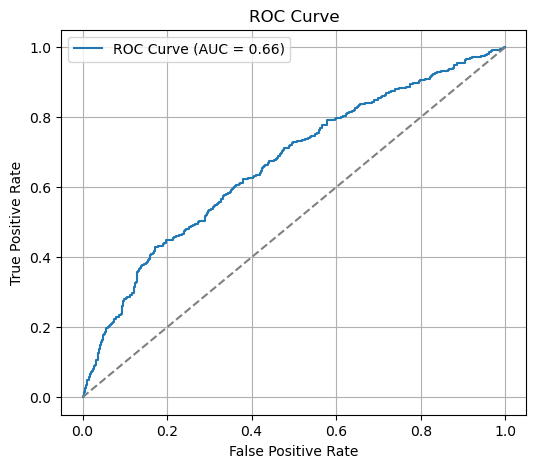

In [11]:
# Convert labels to binary format
y_true_bin = label_binarize(y_true, classes=[0, 1]).ravel()

# Get probabilities
y_probs = []
model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability for class 1
        y_probs.extend(probs.cpu().numpy())

fpr, tpr, _ = roc_curve(y_true_bin, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


In [12]:
import pandas as pd

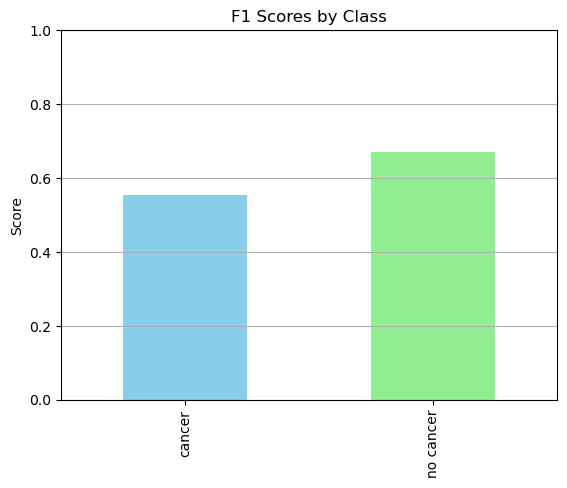

In [13]:
report = classification_report(y_true, y_pred, target_names=train_dataset.classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot F1-scores
report_df.iloc[:-3]['f1-score'].plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title("F1 Scores by Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


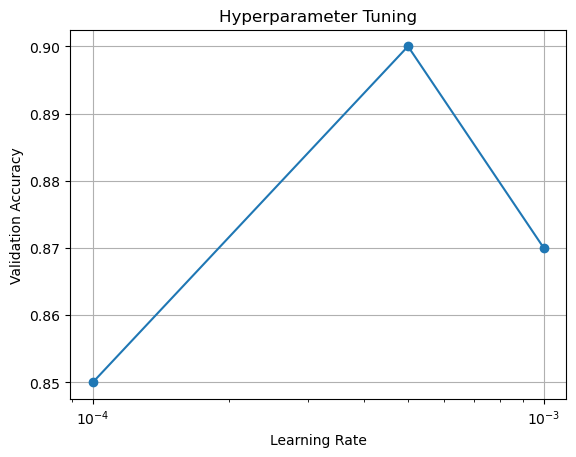

In [14]:
# Example values (replace with your actual tuning results)
learning_rates = [0.001, 0.0005, 0.0001]
val_scores = [0.87, 0.90, 0.85]

plt.plot(learning_rates, val_scores, marker='o')
plt.xscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Validation Accuracy")
plt.title("Hyperparameter Tuning")
plt.grid()
plt.show()


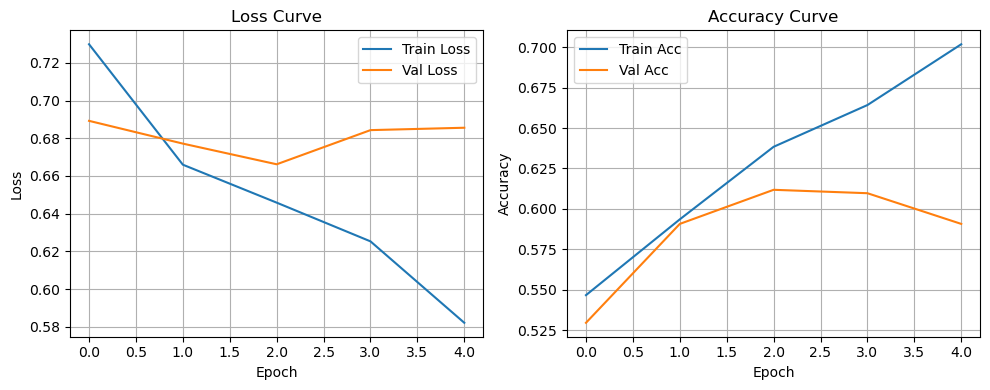

In [15]:
plt.figure(figsize=(10,4))

# Loss Curve
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()

# Accuracy Curve
plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [16]:
model.eval()
example_input = torch.randn(1, 3, 224, 224).to(device)
traced_model = torch.jit.trace(model, example_input)

# Save it
traced_model.save("pneumonia_model_mobile.pt")
print("TorchScript model saved for Android.")


TorchScript model saved for Android.


In [17]:
import streamlit as st
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load model
model = torch.jit.load("pneumonia_model_mobile.pt", map_location="cpu")
model.eval()

# Class labels
classes = ["NORMAL", "PNEUMONIA"]

# Image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Title
st.title("🩻 Pneumonia Detector")

# File uploader
uploaded_file = st.file_uploader("Upload Chest X-ray Image", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    if st.button("🔍 Predict"):
        input_tensor = transform(image).unsqueeze(0)
        with torch.no_grad():
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
            label = classes[predicted.item()]
            st.success(f"Prediction: **{label}**")


2025-07-16 20:46:13.025 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-16 20:46:14.191 
  command:

    streamlit run c:\Users\MUSAWENKOSI NYAWO\miniconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-07-16 20:46:14.191 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-16 20:46:14.191 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-16 20:46:14.191 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-16 20:46:14.191 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-16 20:46:14.208 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-16 20:46:14.208 Thread 'Ma